<a href="https://colab.research.google.com/github/Pineappledeydre/arxiv_2024/blob/main/arXiv_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis of arXiv Articles 2024: Topic Modeling and Visualization**

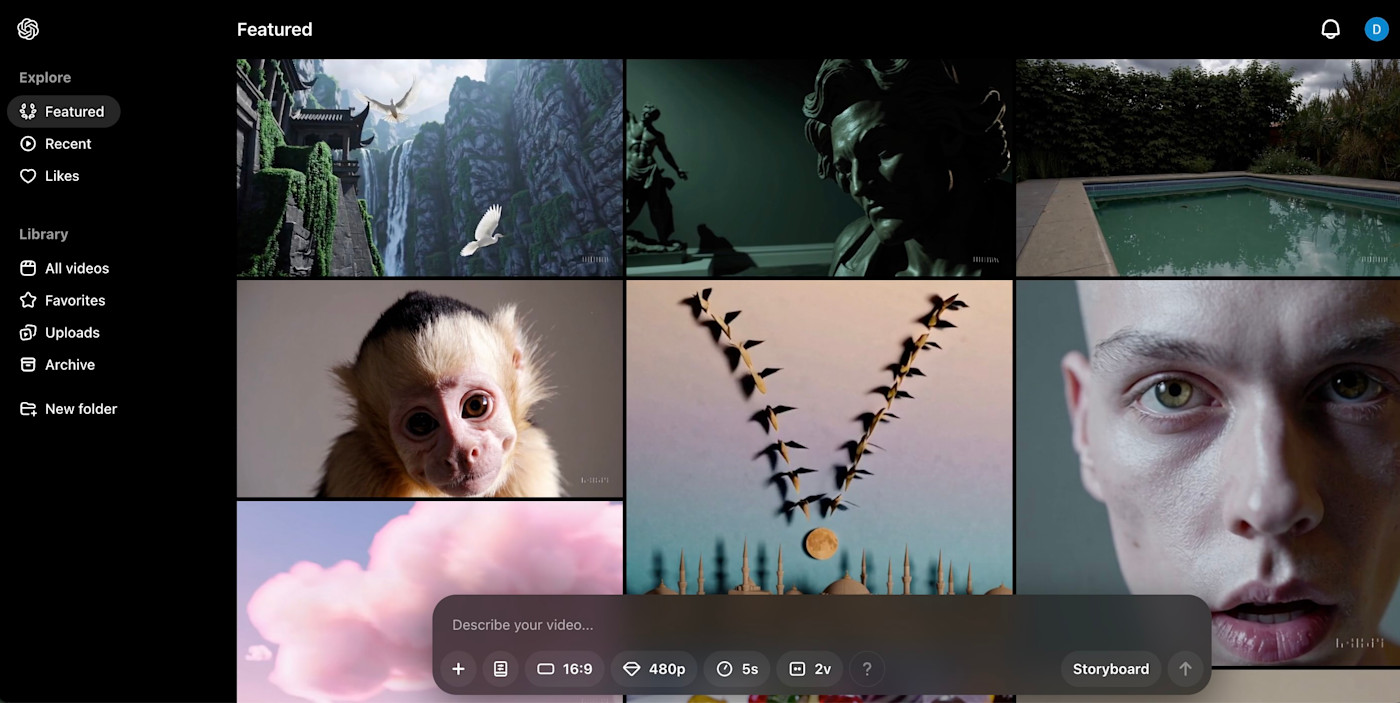

## **Introduction**

This notebook presents an analysis of articles published in 2024 on the topic of "video generation" from the arXiv database.

**Author:** Daria Khokhlacheva  
**Telegram:** [@padeydre](https://t.me/padeydre)  
**Personal Website:** [padeydre.com/about](https://padeydre.com/about)

**Objective** – to collect data using [arxiv.py](https://github.com/lukasschwab/arxiv.py) and the official [API](https://info.arxiv.org/help/api/index.html), perform text preprocessing, carry out topic modeling using NMF, and visualize key trends and the distribution of publications over time.

In this notebook, we analyze articles published in 2024 related to the topic of "video generation".

Using the data obtained from arXiv:
- We load data from arXiv;
- Clean and preprocess the texts;
- Identify topics using TF-IDF and NMF;
- Create visualizations to analyze the temporal distribution and thematic structure of the publications.

## **Installation and Import of Required Libraries**

In [112]:
!pip install arxiv
!pip install pyvis

In [113]:
import re
import arxiv
import time
import calendar
import IPython
from google.colab import files

import spacy
import nltk

from typing import List
from collections import Counter, OrderedDict, defaultdict

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

import networkx as nx
from pyvis.network import Network

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

import seaborn as sns
from wordcloud import WordCloud

## **Loading Data from arXiv**

In this section, we query the arXiv API to search for articles using the keyword "video generation", filtered by the publication year (2024). The results are stored in a DataFrame.

In [114]:
def fetch_arxiv_published_year(search_term, target_year=2024,
                               page_size=200, max_results=5000):
    """
    Search for articles by the given search_term, sorted by submission date
    (SubmittedDate) in descending order. Iterate through the results and stop
    when we encounter an article with published.year < target_year.

    Return a DataFrame with articles where r.published.year == target_year.
    """
    client = arxiv.Client(
        page_size=page_size,
        delay_seconds=4,
        num_retries=3
    )
    search = arxiv.Search(
        query=f'all:"{search_term}"',  # search will be performed across all fields
        max_results=max_results,
        sort_by=arxiv.SortCriterion.SubmittedDate,
        sort_order=arxiv.SortOrder.Descending
    )

    results_iter = client.results(search)
    selected_entries = []

    for result in results_iter:
        if result.published.year < target_year:
            break

        if result.published.year == target_year:
            # print(f"Found article: {result.title} (published: {result.published})")
            selected_entries.append(result)

    data = []
    for r in selected_entries:
        data.append({
            'title': r.title,
            'summary': r.summary,
            'published': r.published,
            'updated': r.updated,
            'link': r.entry_id,
            'authors': ", ".join(a.name for a in r.authors) if r.authors else "",
            'primary_category': r.primary_category,
            'categories': ", ".join(r.categories) if r.categories else "",
            'comment': r.comment,
            'journal_ref': r.journal_ref,
            'doi': r.doi,
        })
    return pd.DataFrame(data)


In [115]:
search_term = "video generation"
target_year = 2024
# print(f"Collecting articles for '{search_term}' (published.year == {target_year})...")
df = fetch_arxiv_published_year(search_term, target_year, page_size=200, max_results=5000)

if not df.empty:
  # print(df[['title', 'published']].head(), "\n")
  df.to_csv(f"arxiv_{target_year}_video_generation.csv", index=False)
else:
  print("No articles found with published.year ==", target_year)

In [116]:
df.head(2)

title  \
0  DreamDrive: Generative 4D Scene Modeling from ...   
1         LTX-Video: Realtime Video Latent Diffusion   

                                             summary  \
0  Synthesizing photo-realistic visual observatio...   
1  We introduce LTX-Video, a transformer-based la...   

                  published                   updated  \
0 2024-12-31 18:59:57+00:00 2025-01-03 20:06:37+00:00   
1 2024-12-30 19:00:25+00:00 2024-12-30 19:00:25+00:00   

                                link  \
0  http://arxiv.org/abs/2501.00601v2   
1  http://arxiv.org/abs/2501.00103v1   

                                             authors primary_category  \
0  Jiageng Mao, Boyi Li, Boris Ivanovic, Yuxiao C...            cs.CV   
1  Yoav HaCohen, Nisan Chiprut, Benny Brazowski, ...            cs.CV   

            categories                                            comment  \
0  cs.CV, cs.AI, cs.GR  Project page: https://pointscoder.github.io/Dr...   
1                cs.CV                                               None   

  journal_ref   doi  
0        None  None  
1        None  None

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   title             634 non-null    object             
 1   summary           634 non-null    object             
 2   published         634 non-null    datetime64[ns, UTC]
 3   updated           634 non-null    datetime64[ns, UTC]
 4   link              634 non-null    object             
 5   authors           634 non-null    object             
 6   primary_category  634 non-null    object             
 7   categories        634 non-null    object             
 8   comment           377 non-null    object             
 9   journal_ref       12 non-null     object             
 10  doi               5 non-null      object             
dtypes: datetime64[ns, UTC](2), object(9)
memory usage: 54.6+ KB


### **Topic Modeling Using NMF**

To extract topics from the abstracts, TF-IDF vectorization and the NMF (Non-negative Matrix Factorization) algorithm are used. The result is a list of topics represented by sets of keywords and an overall weight indicating the importance of each topic.

#### Choice of the No of Topics

In [118]:
nlp = spacy.load("en_core_web_sm")

In [119]:
# Helper: preprocess abstract text
def basic_preprocessor(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_space and token.pos_ in {"NOUN", "PROPN", "ADJ"}]
    return " ".join(lemmas)

if 'df' in locals() and 'summary' in df.columns:
    texts = df['summary'].dropna().tolist()
else:
    texts = []

texts_cleaned = [basic_preprocessor(t) for t in texts]

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



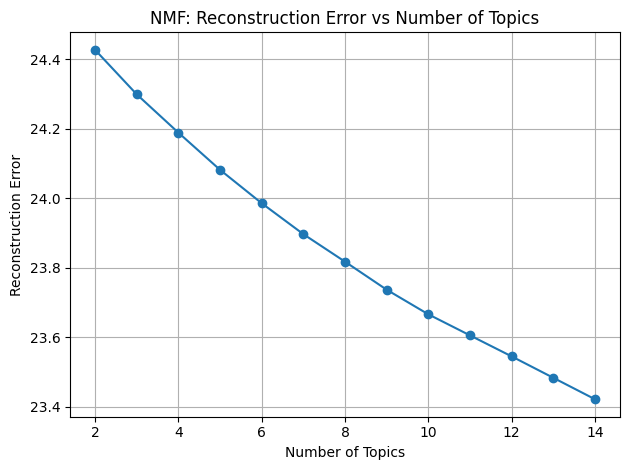

In [120]:
# NMF over a range of topics using reconstruction error
def evaluate_nmf_topics(texts, topic_range=range(2, 15)):
    vectorizer = TfidfVectorizer(
        preprocessor=None,
        tokenizer=lambda x: x.split(),
        stop_words='english',
        ngram_range=(1, 2),
        max_df=0.9,
        min_df=2
    )
    tfidf = vectorizer.fit_transform(texts)

    errors = []
    for n_topics in topic_range:
        nmf = NMF(n_components=n_topics, random_state=42, init='nndsvd', max_iter=500)
        nmf.fit(tfidf)
        errors.append(nmf.reconstruction_err_)

    return topic_range, errors

topic_range, errors = evaluate_nmf_topics(texts_cleaned)

# Plot reconstruction error
plt.plot(topic_range, errors, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Reconstruction Error")
plt.title("NMF: Reconstruction Error vs Number of Topics")
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Δ Reconstruction Error')

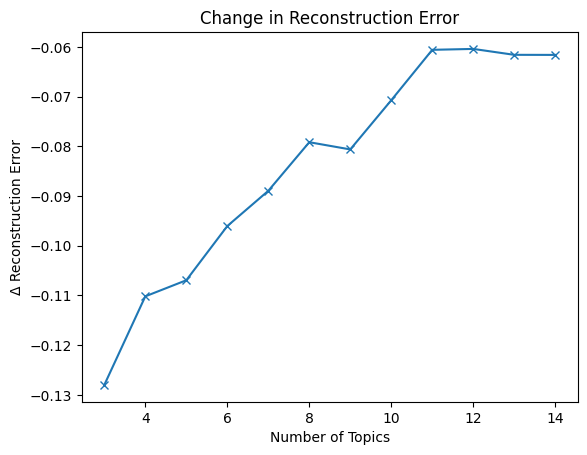

In [121]:
# the derivative (i.e., change in error) t
delta_errors = np.diff(errors)
plt.plot(topic_range[1:], delta_errors, marker='x')
plt.title("Change in Reconstruction Error")
plt.xlabel("Number of Topics")
plt.ylabel("Δ Reconstruction Error")

##### **Interpretation**:

- The curve shows that the **rate of improvement** slows significantly **after 10 topics**.
- From **topic 11 onward**, the change in reconstruction error becomes almost flat (plateauing near −0.06).
- This supports choosing **10 topics**:
  - It captures most of the variation in the data.
  - Further increases yield **diminishing returns** in interpretability.

#### **Choice of the No of Words**

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



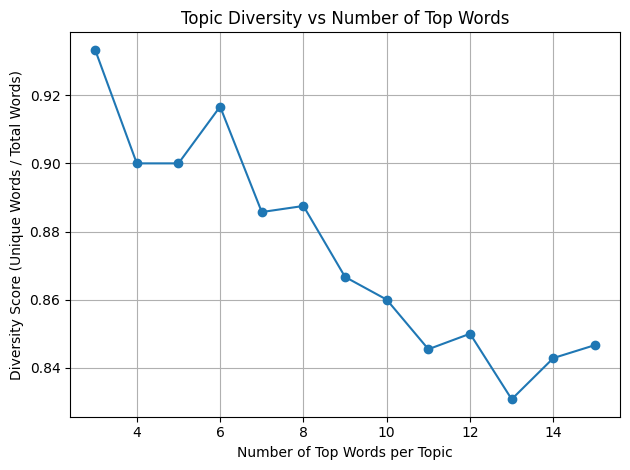

In [122]:
# Fixed number of topics - 10 - as discussed adove
fixed_n_topics = 10
n_top_word_range = range(3, 16)

vectorizer = TfidfVectorizer(
    preprocessor=None,
    tokenizer=lambda x: x.split(),
    stop_words='english',
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=2
)
tfidf = vectorizer.fit_transform(texts_cleaned)
feature_names = vectorizer.get_feature_names_out()

# Fit NMF
nmf_model = NMF(n_components=fixed_n_topics, init='nndsvd', random_state=42, max_iter=500)
nmf_model.fit(tfidf)

# Diversity for different n_top_words
diversity_scores = []
for n_top_words in n_top_word_range:
    all_top_words = []
    for topic in nmf_model.components_:
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        words = [feature_names[idx] for idx in top_indices]
        all_top_words.extend(words)
    unique_words = len(set(all_top_words))
    total_words = fixed_n_topics * n_top_words
    diversity = unique_words / total_words
    diversity_scores.append(diversity)

plt.plot(n_top_word_range, diversity_scores, marker='o')
plt.title("Topic Diversity vs Number of Top Words")
plt.xlabel("Number of Top Words per Topic")
plt.ylabel("Diversity Score (Unique Words / Total Words)")
plt.grid(True)
plt.tight_layout()
plt.show()


##### **Interpretation of Topic Diversity Curve**

- **Peak diversity is at n_top_words = 3 and n_top_words = 6**
- After **6**, the score **starts dropping**, indicating increasing word repetition across topics
- Therefore, **n_top_words = 6** is a good choice:
  - High uniqueness
  - Still enough context to interpret the topic

In [123]:
def extract_topics_nmf(texts, n_topics, n_top_words=6, evaluate=False, sort_by_weight=True):
    """
    Performs topic modeling of abstracts using TF-IDF and NMF, and optionally evaluates NMF across topic numbers.

    Parameters:
      - texts: list of strings (preprocessed abstracts)
      - n_topics: number of topics to extract (based on prior evaluation)
      - n_top_words: number of top words to consider per topic (before filtering)
      - evaluate: if True, runs topic_range=range(2,15) and plots reconstruction error
      - sort_by_weight: if True, sorts topics by total topic weight

    Returns:
      - nmf_model: trained NMF model
      - feature_names: vectorizer vocabulary
      - topic_sentences: ["Topic 1: key terms — ..." ]
      - topic_word_lists: [["term1", "term2", ...], ...]
      - topic_indices: [original_topic_index_0, ...] for correct mapping
      - reconstruction_err: float
    """

    # Hhelper to remove overlapping shorter n-grams
    def filter_redundant(words):
        sorted_words = sorted(words, key=len, reverse=True)
        filtered = []
        for w in sorted_words:
            if not any(w in fw and w != fw for fw in filtered):
                filtered.append(w)
        return list(OrderedDict.fromkeys(filtered))

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(
        preprocessor=basic_preprocessor,
        stop_words='english',
        ngram_range=(1, 2),
        max_df=0.9,
        min_df=2
    )
    tfidf = vectorizer.fit_transform(texts)

    # optional evaluation
    if evaluate:
        import matplotlib.pyplot as plt
        topic_range = range(2, 15)
        errors = []
        for k in topic_range:
            model = NMF(n_components=k, init='nndsvd', random_state=42, max_iter=500)
            model.fit(tfidf)
            errors.append(model.reconstruction_err_)

        plt.plot(topic_range, errors, marker='o')
        plt.title("NMF: Reconstruction Error vs Number of Topics")
        plt.xlabel("Number of Topics")
        plt.ylabel("Reconstruction Error")
        plt.grid(True)
        plt.show()

    nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvd', max_iter=500)
    nmf_model.fit(tfidf)
    feature_names = vectorizer.get_feature_names_out()

    topic_info = []
    for i, topic in enumerate(nmf_model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        raw_words = [feature_names[idx] for idx in top_indices]
        words = filter_redundant(raw_words)
        total_weight = topic[top_indices].sum()
        topic_info.append((i, words, total_weight))  # i = original topic index

    # sort by weight if requested
    if sort_by_weight:
        topic_info = sorted(topic_info, key=lambda x: x[2], reverse=True)

    # final outputs
    topic_sentences = []
    topic_word_lists = []
    topic_weights = []
    topic_indices = []

    for rank, (i, words, weight) in enumerate(topic_info, 1):
        sentence = f"Topic {rank}: key terms — {', '.join(words)} (total weight: {weight:.2f})."
        topic_sentences.append(sentence)
        topic_word_lists.append(words)
        topic_weights.append(weight)
        topic_indices.append(i)  #  original topic index from nmf.components_

    return nmf_model, feature_names, topic_sentences, topic_word_lists, topic_weights, topic_indices, nmf_model.reconstruction_err_


In [124]:
nmf_model, feature_names, topic_sentences, topic_words, topic_weights, topic_indices, error = extract_topics_nmf(
    texts_cleaned,
    n_topics=10,
    n_top_words=6,
    evaluate=False,
    sort_by_weight=True
)

In [125]:
print("Main Topics/Trends:")
for sentence in topic_sentences:
    print(sentence)

print("\nTop Words Lists for Each Topic:")
for i, words in enumerate(topic_words, start=1):
    print(f"Topic {i}: {words}")

Main Topics/Trends:
Topic 1: key terms — diffusion model, video diffusion, frame, step (total weight: 3.59).
Topic 2: key terms — consistency, multi view, object, scene (total weight: 3.00).
Topic 3: key terms — camera movement, camera control, camera motion (total weight: 2.64).
Topic 4: key terms — audio visual, audio video, video audio, head, lip (total weight: 2.51).
Topic 5: key terms — object motion, trajectory, appearance, control (total weight: 2.47).
Topic 6: key terms — world model, action, policy, robot (total weight: 2.39).
Topic 7: key terms — text video, quality, prompt, metric, model (total weight: 2.21).
Topic 8: key terms — video generation, autoregressive, long video, frame, short (total weight: 2.20).
Topic 9: key terms — diffusion transformer, quantization, attention, inference, dit (total weight: 2.06).
Topic 10: key terms — image video, reference, identity, editing, method (total weight: 2.00).

Top Words Lists for Each Topic:
Topic 1: ['diffusion model', 'video d

#### **Topic Modeling - Conclusion**

1. **Diffusion models** : the dominant approach in video generation.
2. **Multi-view consistency** and **object realism** are crucial research areas.
3. Papers explore **camera control** and **cinematic motion**.
4. **Audio-visual alignment** is an active topic.
5. Focus on **object motion** and **trajectory modeling**.
6. Interest in **world models** and **robotic policy learning**.
7. **Text-to-video** generation and **evaluation metrics** are emphasized.
8. Work is expanding into **long-form video generation**.
9. Use of **transformers** and **quantization techniques** is growing.
10. Attention to **video editing** and **identity preservation**.

## **Pre-Processing**

In this section, the text data (abstracts and titles) is cleaned – unnecessary characters are removed, the text is converted to lowercase, and lemmatization is performed.

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   title             634 non-null    object             
 1   summary           634 non-null    object             
 2   published         634 non-null    datetime64[ns, UTC]
 3   updated           634 non-null    datetime64[ns, UTC]
 4   link              634 non-null    object             
 5   authors           634 non-null    object             
 6   primary_category  634 non-null    object             
 7   categories        634 non-null    object             
 8   comment           377 non-null    object             
 9   journal_ref       12 non-null     object             
 10  doi               5 non-null      object             
dtypes: datetime64[ns, UTC](2), object(9)
memory usage: 54.6+ KB


1. **Total Number of Articles**: 634 records are related to the topic *video generation* based on keywords, categories, and descriptions (published in 2024).

2. **Key Fields**:
   - Fields describing the content and identifiers of the articles:
     - title, summary, authors, primary_category, categories, link
     - comment:  
       Comments are present in approximately 59% of the articles (377 out of 636).
     - journal_ref:  Filled in only 12 cases.
     - doi: Assigned to only 5 articles. Most publications in the dataset may not have completed the DOI assignment process yet(?)

3. **Publication/Update Date and Time**:
   - The `published` and `updated` columns are stored in datetime64[ns, UTC] format.

4. **Category Assignment**:
   - Each article has a primary_category as well as a full set of categories listed in the categories field.

In [127]:
def preprocess_text(text):
    # lowercase, remove punctuation/digits, normalize spacing
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # lemmatize & filter by POS
    doc = nlp(text)
    lemmas = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and token.pos_ in {'NOUN', 'PROPN', 'ADJ'}
    ]
    return " ".join(lemmas)

df['summary_clean'] = df['summary'].fillna("").apply(preprocess_text)
df['title_clean'] = df['title'].fillna("").apply(preprocess_text)


## **Visualization**


### Topic and Keyword Graph

Construction of a graph where the nodes represent topics and keywords, and the edges between them indicate the contribution of each keyword to the formation of the corresponding topic.

In [128]:
def visualize_topics_as_pyvis(nmf_model, feature_names, topic_words, topic_indices, output_html="topic_graph_interactive.html"):
    """
    Builds a topic-word graph using Pyvis.
    - Color-coded topics
    - Hover tooltips
    - Smart layout with longer edges
    - Smaller font edge weights
    """
    G = nx.Graph()
    word2index = {word: i for i, word in enumerate(feature_names)}
    n_topics = len(topic_words)
    colormap = cm.get_cmap('Pastel1')

    topic_colors = [mcolors.to_hex(colormap(i)) for i in range(n_topics)]

    for i in range(n_topics):
        topic_node = f"Topic {i + 1}"
        true_topic_idx = topic_indices[i]
        topic_row = nmf_model.components_[true_topic_idx]
        color = topic_colors[i]

        # topic node
        G.add_node(
            topic_node,
            label=topic_node,
            title=f"{topic_node}<br>Top keywords: {', '.join(topic_words[i])}",
            color=color,
            shape='box',
            size=65
        )

        for word in topic_words[i]:
            if word not in word2index:
                continue
            weight = float(topic_row[word2index[word]])

            if weight > 0.001:
                # Add word node (if not already added)
                if not G.has_node(word):
                    G.add_node(
                        word,
                        label=word,
                        title=f"Word: {word}",
                        color='#cccdcd',
                        shape='ellipse',
                        size=50
                    )

                # edge from topic → word
                G.add_edge(
                    topic_node,
                    word,
                    value=weight * 5,
                    title=f"Weight: {weight:.4f}",
                    label=f"{weight:.2f}",
                    font={'size': 8}
                )

    # Pyvis network
    net = Network(height="900px", width="100%", notebook=True, cdn_resources='in_line')
    net.from_nx(G)

    # layout with longer edge spacing
    net.set_options("""
    {
      "nodes": {
        "font": {
          "size": 18,
          "face": "arial"
        }
      },
      "edges": {
        "smooth": {
          "type": "dynamic"
        }
      },
      "physics": {
        "forceAtlas2Based": {
          "gravitationalConstant": -50,
          "centralGravity": 0.005,
          "springLength": 250,
          "springConstant": 0.08
        },
        "solver": "forceAtlas2Based",
        "timestep": 0.35,
        "stabilization": {
          "iterations": 150
        }
      }
    }
    """)

    net.show(output_html)
    print(f"Pyvis HTML graph saved as '{output_html}'")


In [129]:
visualize_topics_as_pyvis(nmf_model, feature_names, topic_words, topic_indices)
# files.download("topic_graph_interactive.html")

<ipython-input-128-33dd5da7a097>:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



topic_graph_interactive.html
Pyvis HTML graph saved as 'topic_graph_interactive.html'


In [130]:
IPython.display.HTML(filename='/content/topic_graph_interactive.html')

### Visualization of Publications Over Time

Plots are created to show the distribution of publications by month and day of the week, as well as the dynamics of key keywords over the months.

In [131]:
df['month'] = df['published'].dt.month
df['weekday'] = df['published'].dt.dayofweek  # 0 = Monday
#df.weekday.value_counts()

<ipython-input-132-64cf18d5b66b>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




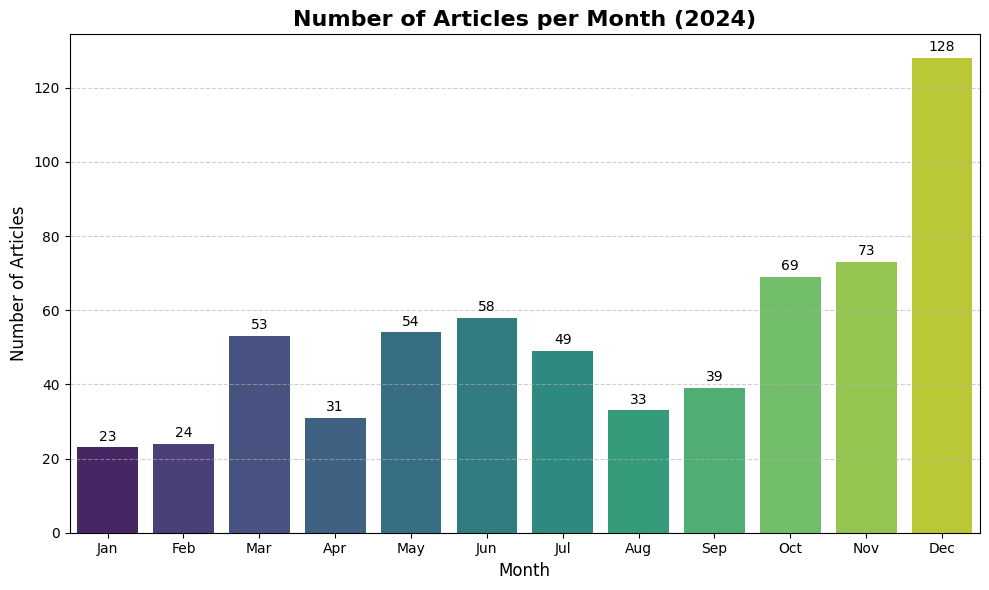

In [132]:
# Distribution of articles by month
monthly_counts = df['month'].value_counts().sort_index()
month_labels = [calendar.month_abbr[m] for m in monthly_counts.index]

plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x=month_labels, y=monthly_counts.values, palette="viridis")
plt.title("Number of Articles per Month (2024)", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add values above the bars
for i, val in enumerate(monthly_counts.values):
    ax1.text(i, val + 1, str(val), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**Number of Articles per Month (2024)**

- A **steady increase in activity** is observed throughout the year.  
- The peak of publications occurred in **December** — **128 articles**, which accounts for **over 20%** of the entire dataset.  
- High publication numbers were also seen in **November (73)** and **October (69)**.  
- The lowest number of publications was in **January (23)** and **February (24)**.

**Conclusion:** Activity on the topic of *video generation* rises significantly in the second half of the year, especially in the fourth quarter.

<ipython-input-133-1e4d73dd6c39>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




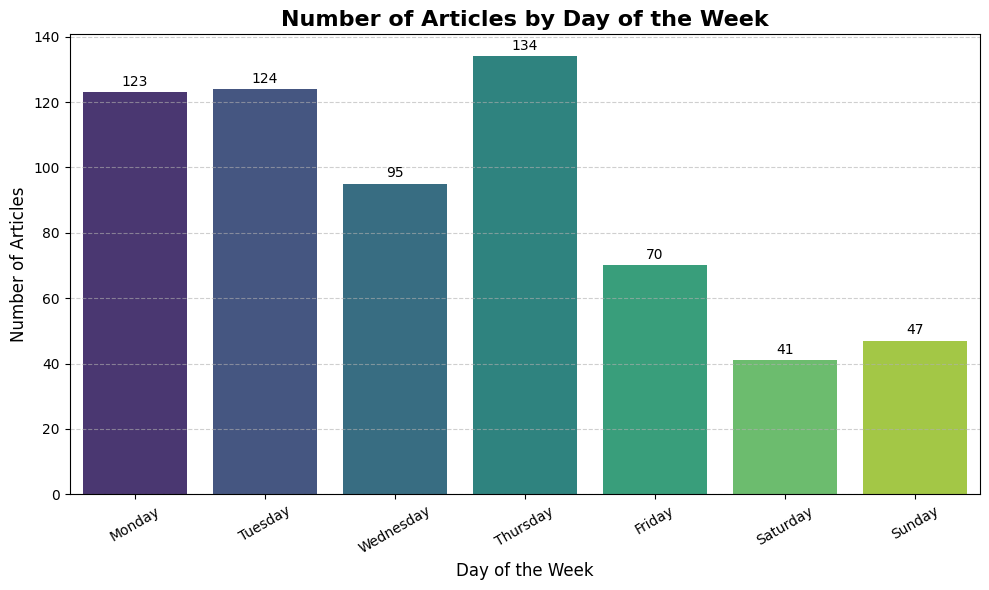

In [133]:
# Distribution by day of the week
df['weekday'] = df['published'].dt.dayofweek  # 0 = Monday
weekday_counts = df['weekday'].value_counts().sort_index()
weekday_labels = [calendar.day_name[i] for i in weekday_counts.index]

plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x=weekday_labels, y=weekday_counts.values, palette="viridis")
plt.title("Number of Articles by Day of the Week", fontsize=16, fontweight='bold')
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# values above the bars
for i, val in enumerate(weekday_counts.values):
    ax2.text(i, val + 1, str(val), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

**Number of Articles by Day of the Week**

- The highest number of articles is published on **Thursday (134)**, **Tuesday (124)**, and **Monday (123)**.  
- The lowest activity is observed on **Saturday (41)** and **Sunday (47)**.

**Conclusion:** Most publications on the topic appear on weekdays, especially in the first half of the week.

### Analysis of Frequent Phrases and Authors

Next, charts of frequent bigrams/trigrams are generated, and authors with a high number of publications as well as article categories are analyzed.

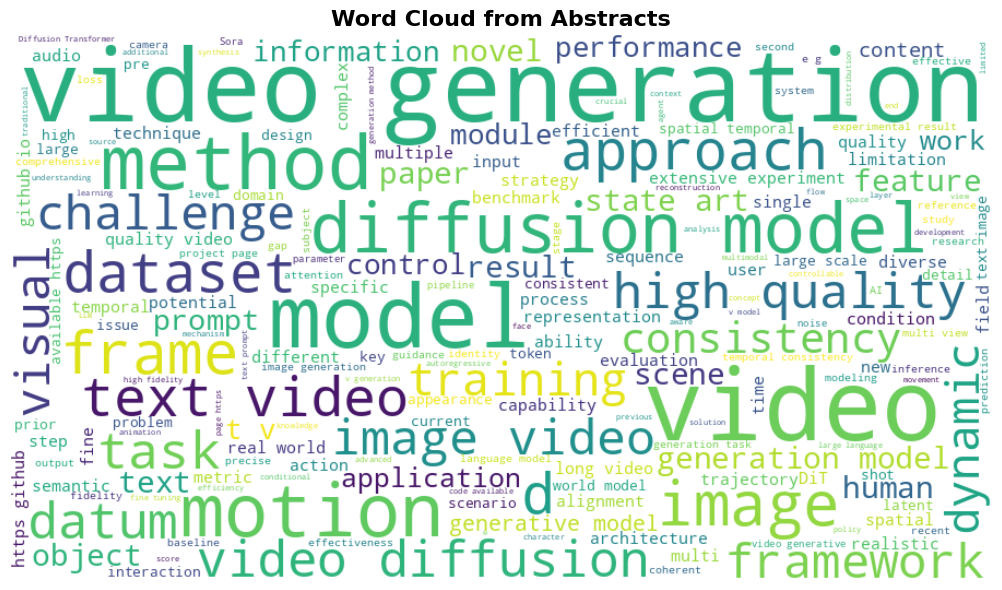

In [134]:
# Word Cloud
text_blob = " ".join(df['summary_clean'])
wordcloud = WordCloud(width=900, height=500, background_color='white', colormap='viridis').generate(text_blob)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud from Abstracts", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [135]:
def plot_topic_wordclouds(nmf_model, feature_names, topic_indices=None, cols=2, max_words=50):
    """
    Displays one word cloud per topic using full NMF weights.

    Parameters:
        - nmf_model: trained NMF model
        - feature_names: TF-IDF vocabulary
        - topic_indices: (optional) mapping of sorted topics (used with sort_by_weight=True)
        - cols: number of columns in subplot grid
        - max_words: max number of words in each cloud
    """
    components = nmf_model.components_
    n_topics = components.shape[0]
    topic_order = topic_indices if topic_indices else range(n_topics)

    rows = (n_topics + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axs = axs.flatten()

    for i, topic_idx in enumerate(topic_order):
        topic_weights = components[topic_idx]
        freqs = {
            feature_names[j]: topic_weights[j]
            for j in topic_weights.argsort()[-max_words:]
            if topic_weights[j] > 0
        }

        wc = WordCloud(
            width=400,
            height=300,
            background_color='white',
            colormap='viridis'
        ).generate_from_frequencies(freqs)

        axs[i].imshow(wc, interpolation='bilinear')
        axs[i].axis('off')
        axs[i].set_title(f"Topic {i + 1}", fontsize=14, fontweight='bold')

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


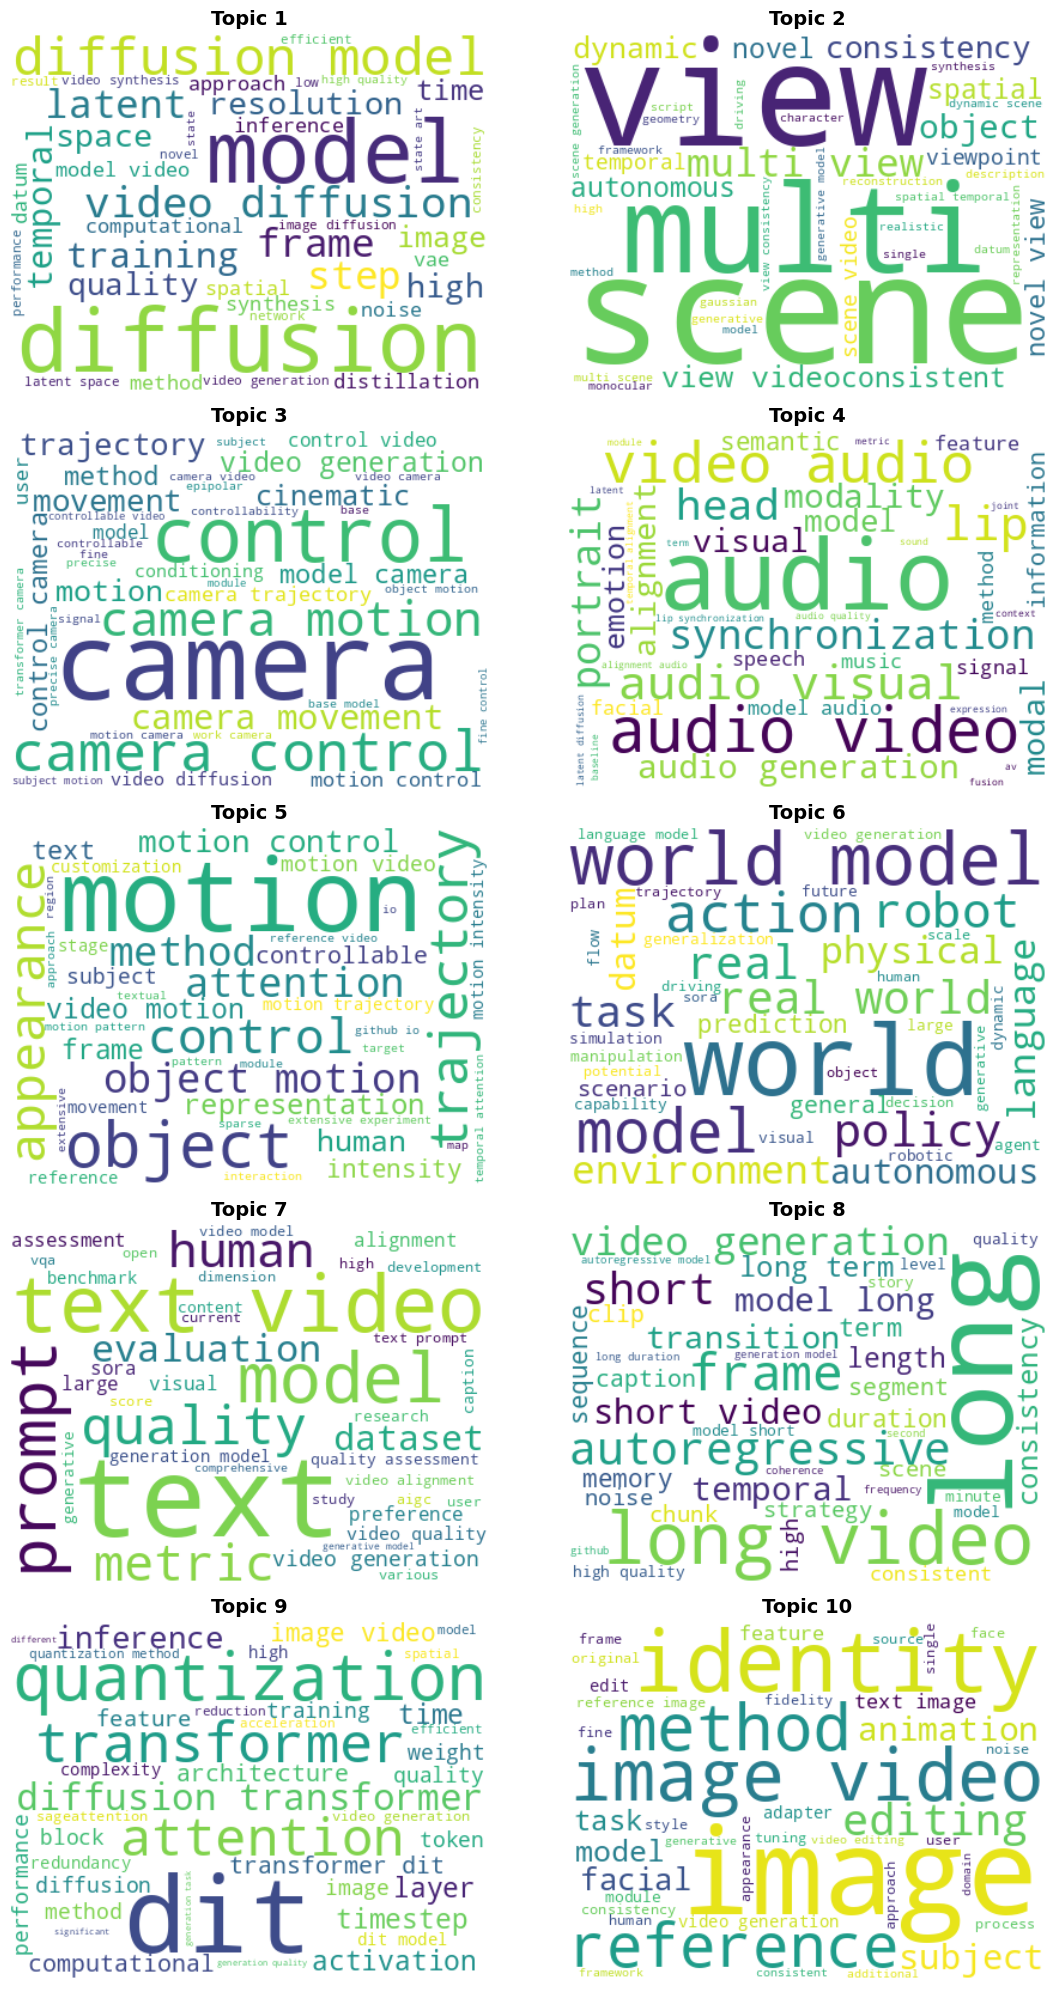

In [136]:
plot_topic_wordclouds(nmf_model, feature_names, topic_indices=topic_indices, cols=2, max_words=40)

**Word Cloud from Abstracts**

- The most prominent (frequently occurring) words are: **video**, **generation** (naturally, as they were used in the search), **model**, **diffusion**, **image**, **motion**, **frame**, **approach**, **method**, **dataset**.  
- There is a strong presence of terms related to:
  - video generation (`video generation`, `generate`, `frame`, `image`);
  - diffusion models (`diffusion`, `diffusion model`);
  - architectures and methods (`model`, `approach`, `training`, `task`, `control`).

**Conclusion:** The abstracts emphasize a focus on generation techniques, the use of diffusion models, motion, and model architectures.

<ipython-input-137-63d3c5b319c8>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




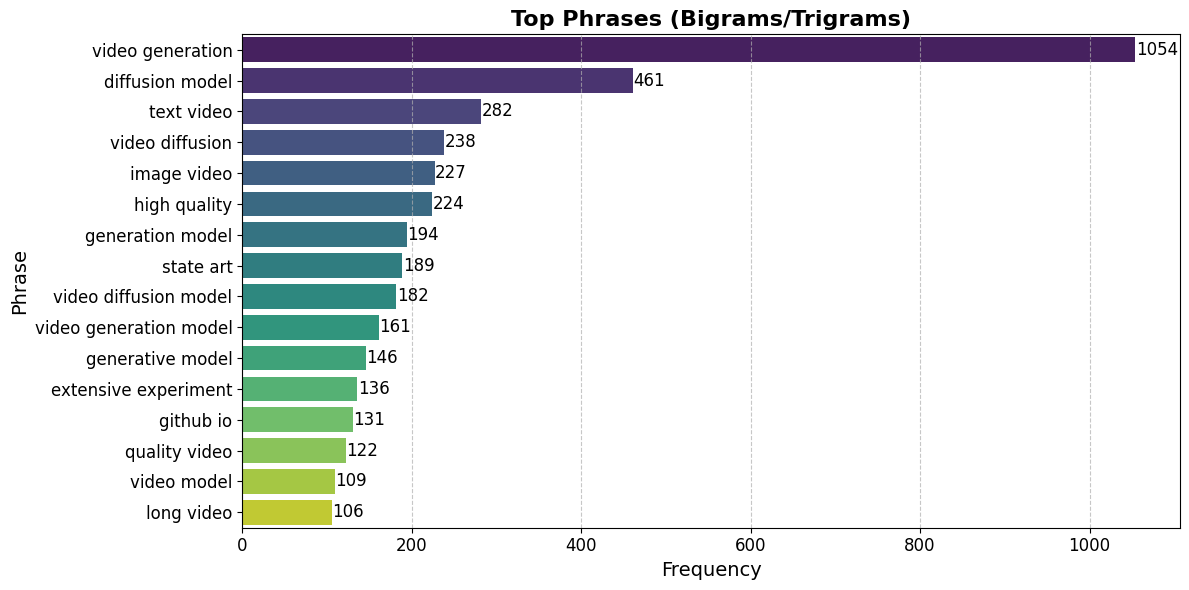

In [137]:
# Common Phrases
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english', max_features=16)
X = vectorizer.fit_transform(df['summary_clean'])
ngrams = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

sorted_idx = np.argsort(counts)[::-1]
ngrams_sorted = ngrams[sorted_idx]
counts_sorted = counts[sorted_idx]

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=counts_sorted, y=ngrams_sorted, palette="viridis")
plt.title("Top Phrases (Bigrams/Trigrams)", fontsize=16, weight="bold")
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Phrase", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle="--", alpha=0.7)

for i, count in enumerate(counts_sorted):
    plt.text(count + 0.5, i, str(count), color='black', va="center", fontsize=12)

plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

**Top Phrases (Bigrams/Trigrams)**

- The absolute leader is **video generation** (**1054 occurrences**).
- Other frequent phrases include: **diffusion model**, **text video**, **image video**, **video diffusion**.
- Some technical expressions also appear, such as: `extensive experiment`, `experiment demonstrate`, `highquality video`.

**Conclusion:** The word combinations confirm the dominant role of diffusion models in the field of video generation. There is also a strong emphasis on experimental research and the generation of high-quality video content.

<ipython-input-138-78bf21295092>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




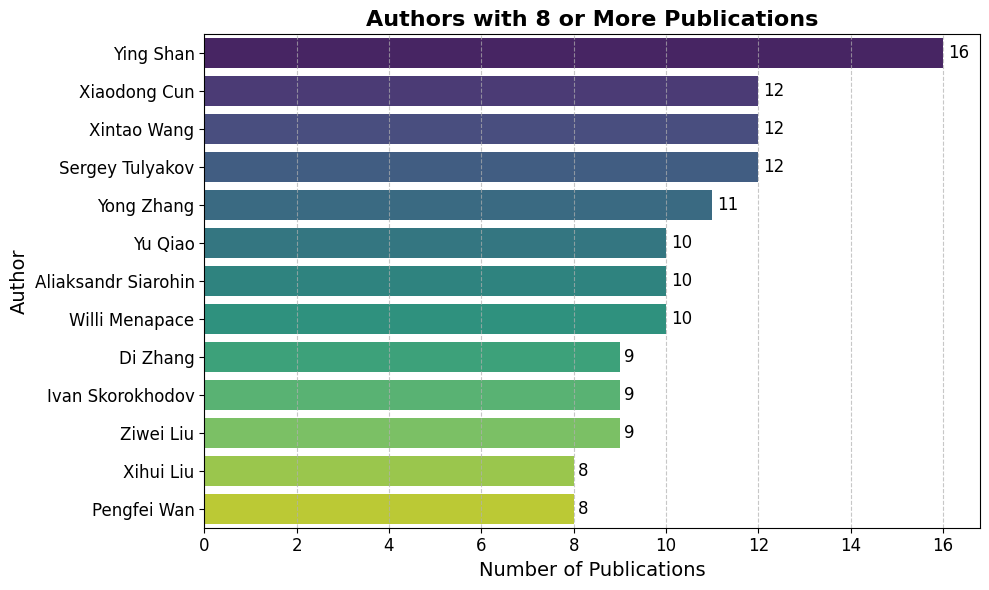

In [138]:
# Authors
author_counts = df['authors'].str.split(', ').explode().value_counts()
top_authors = author_counts[author_counts >= 8]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_authors.values, y=top_authors.index, palette="viridis")
plt.title("Authors with 8 or More Publications", fontsize=16, weight="bold")
plt.xlabel("Number of Publications", fontsize=14)
plt.ylabel("Author", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Add numeric labels to the bars
for i, value in enumerate(top_authors.values):
    plt.text(value + 0.1, i, str(value), color='black', va='center', fontsize=12)

plt.tight_layout()
plt.show()

**Authors with 8 or More Publications**

- **Ying Shan** leads with the highest number of publications (**16**), followed by **Xintao Wang**, **Xiaodong Cun**, and **Sergey Tulyakov** — each with **12**.  
- These names are active researchers in the fields of computer vision and generative models (in 2024).

**Conclusion:** A core group of authors has been identified who are actively working on video generation tasks.

#### **Deeper Analysis of the Authors**

In [139]:
# List of authors for further analysis
top_authors = list(top_authors.index)

def fetch_articles_by_author(author, max_results=50):
    """
    Retrieves publications by the specified author from arXiv.

    Parameters:
      author (str): author's name
      max_results (int): maximum number of results

    Returns:
      DataFrame with metadata of the author's articles.
    """
    client = arxiv.Client()
    search = arxiv.Search(
        query=f'au:"{author}"',
        max_results=max_results,
        sort_by=arxiv.SortCriterion.SubmittedDate,
        sort_order=arxiv.SortOrder.Descending
    )
    results = list(client.results(search))
    entries = []
    for r in results:
        entries.append({
            'author_query': author,
            'title': r.title,
            'summary': r.summary,
            'published': r.published,
            'updated': r.updated,
            'link': r.entry_id,
            'primary_category': r.primary_category,
        })
    return pd.DataFrame(entries)

# Collect articles for each author from the list
all_dfs = []
for author in top_authors:
    print(f"Fetching articles for {author}...")
    df_author = fetch_articles_by_author(author, max_results=700)
    all_dfs.append(df_author)

df_authors = pd.concat(all_dfs, ignore_index=True)
df_authors['title_clean'] = df_authors['title'].fillna("").apply(preprocess_text)
print("Total number of retrieved publications:", len(df_authors))
df_authors.head()
# df_authors.to_csv("top_authors_articles.csv", index=False)

Fetching articles for Ying Shan...
Fetching articles for Xiaodong Cun...
Fetching articles for Xintao Wang...
Fetching articles for Sergey Tulyakov...
Fetching articles for Yong Zhang...
Fetching articles for Yu Qiao...
Fetching articles for Aliaksandr Siarohin...
Fetching articles for Willi Menapace...
Fetching articles for Di Zhang...
Fetching articles for Ivan Skorokhodov...
Fetching articles for Ziwei Liu...
Fetching articles for Xihui Liu...
Fetching articles for Pengfei Wan...
Total number of retrieved publications: 2574


author_query                                              title  \
0    Ying Shan  GeometryCrafter: Consistent Geometry Estimatio...   
1    Ying Shan  AnimeGamer: Infinite Anime Life Simulation wit...   
2    Ying Shan  Exploring the Effect of Reinforcement Learning...   
3    Ying Shan  Mono2Stereo: A Benchmark and Empirical Study f...   
4    Ying Shan  GenHancer: Imperfect Generative Models are Sec...   

                                             summary  \
0  Despite remarkable advancements in video depth...   
1  Recent advancements in image and video synthes...   
2  Recent advancements in Chain of Thought (COT) ...   
3  With the rapid proliferation of 3D devices and...   
4  The synergy between generative and discriminat...   

                  published                   updated  \
0 2025-04-01 17:58:03+00:00 2025-04-01 17:58:03+00:00   
1 2025-04-01 17:57:18+00:00 2025-04-01 17:57:18+00:00   
2 2025-03-31 17:55:23+00:00 2025-03-31 17:55:23+00:00   
3 2025-03-28 09:25:58+00:00 2025-03-28 09:25:58+00:00   
4 2025-03-25 09:15:34+00:00 2025-03-25 09:15:34+00:00   

                                link primary_category  \
0  http://arxiv.org/abs/2504.01016v1            cs.GR   
1  http://arxiv.org/abs/2504.01014v1            cs.CV   
2  http://arxiv.org/abs/2503.24376v1            cs.CV   
3  http://arxiv.org/abs/2503.22262v1            cs.CV   
4  http://arxiv.org/abs/2503.19480v1            cs.CV   

                                         title_clean  
0  GeometryCrafter Consistent Geometry Estimation...  
1  AnimeGamer Infinite Anime Life Simulation Game...  
2  Effect Reinforcement Learning Video Understand...  
3  Mono Stereo Benchmark Empirical Study Stereo C...  
4  GenHancer Imperfect Generative Models strong V...

Total number of publications in 2024: 679


<ipython-input-140-395d3ddbd7ef>:19: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



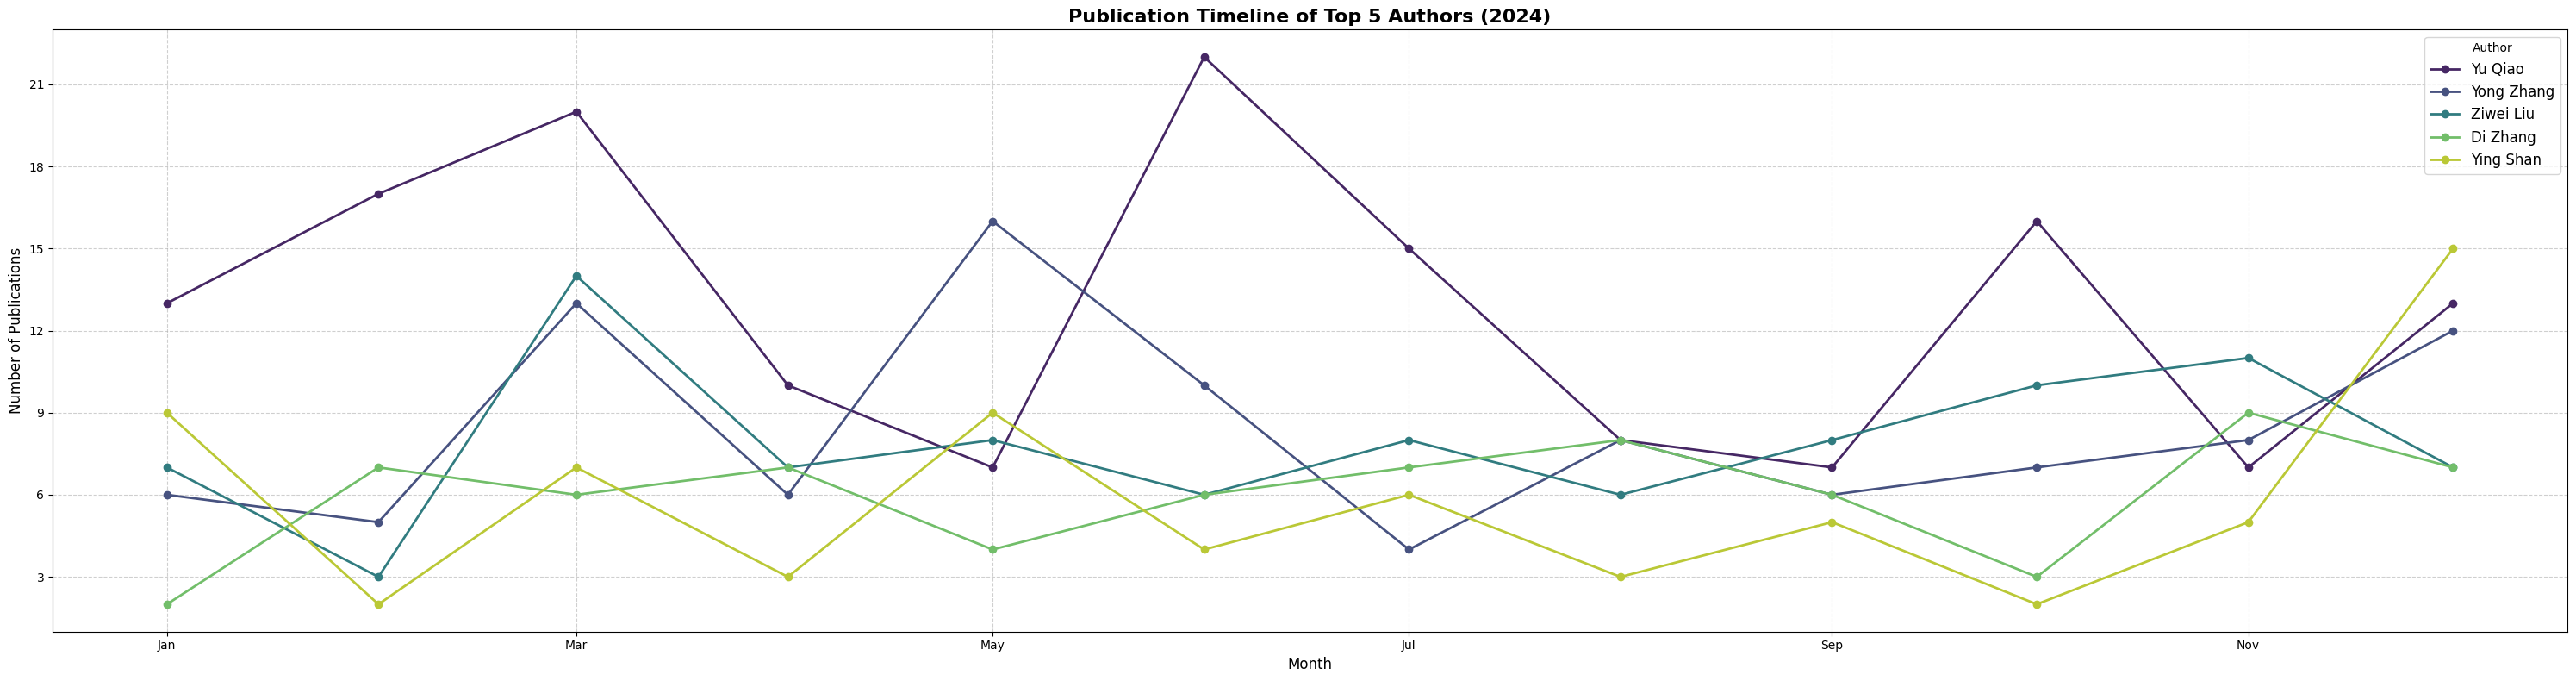

In [140]:
colors = ["#462764", "#475280", "#317C80", "#72BE6A", "#BAC836"]

# df_authors['published'] = pd.to_datetime(df_authors['published'], errors='coerce', utc=True)

df_authors_2024 = df_authors[df_authors['published'].dt.year == 2024].copy()
print("Total number of publications in 2024:", len(df_authors_2024))

authors_series = df_authors_2024['author_query'].str.split(', ').explode()
top_authors = authors_series.value_counts()
top5_authors = top_authors.index[:5].tolist()

df_filtered = (
    df_authors_2024[df_authors_2024['author_query'].str.contains('|'.join(top5_authors))]
    .assign(author=lambda d: d['author_query'].str.split(', '))
    .explode('author')
    .loc[lambda d: d['author'].isin(top5_authors)]
)

df_filtered['month'] = df_filtered['published'].dt.to_period('M').dt.to_timestamp()
timeline = df_filtered.groupby(['month', 'author']).size().unstack(fill_value=0)

all_months = pd.date_range("2024-01-01", "2024-12-01", freq="MS")
timeline = timeline.reindex(all_months, fill_value=0)
timeline.index.name = 'Month'

plt.figure(figsize=(30, 8))
for i, author in enumerate(top5_authors):
    plt.plot(timeline.index, timeline[author], marker="o", linewidth=2, label=author, color=colors[i])
plt.title("Publication Timeline of Top 5 Authors (2024)", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Publications", fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(title="Author", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Conclusions**

1. **Yu Qiao** is the leader in terms of publication count:  
   - Consistently ranks first in most months.  
   - Peak activity is observed in **June**, with **over 21 articles published**.

2. **Yong Zhang** and **Ziwei Liu** are steady contributors:  
   - They publish every month.  
   - **Yong Zhang** peaks in May.  
   - **Ziwei Liu** shows a gradual increase in publication activity, with peaks in March and a smaller one in November.

3. **Ying Shan** shows steady growth towards the end of the year:  
   - Starts moderately but reaches a personal publication peak in **December**.  
   - Notably, **he leads in the *video generation* subdomain**.

4. **Di Zhang** is the quietest among the top 5:  
   - Has fewer total publications compared to the others.  
   - Nevertheless, maintains steady activity across most months with slight fluctuations.

Interestingly, **3 of the Top-5 authors in *video generation*** — Xintao Wang, Xiaodong Cun, and Sergey Tulyakov — **did not appear in the overall Top-5 by total publications**.  
This suggests that some of the most prolific authors in *video generation* are more specialized, while others in the overall Top-5 may be publishing more broadly across different topics.

##### **Top Authors Collaborations**

In [141]:
df_authors_2024.author_query.value_counts()

author_query
Yu Qiao                155
Yong Zhang             101
Ziwei Liu               95
Di Zhang                72
Ying Shan               70
Sergey Tulyakov         37
Xintao Wang             34
Xihui Liu               29
Pengfei Wan             22
Xiaodong Cun            19
Aliaksandr Siarohin     19
Willi Menapace          14
Ivan Skorokhodov        12
Name: count, dtype: int64

In [142]:
top_authors = top_authors.index.tolist()

# 1) All top authors (all topics) — filter to top_authors only
df_top_all_topics = df_authors_2024[df_authors_2024['author_query'].isin(top_authors)]

# 2) Top authors but only for video generation papers — filter both title and author
df_top_authors_videogen = df_authors_2024[
    df_authors_2024['title_clean'].isin(df['title_clean']) &
    df_authors_2024['author_query'].isin(top_authors)
]

# 3) 50 top authors involved in video generation
df_all_authors_videogen = df.copy()
df_all_authors_videogen['author_query'] = df_all_authors_videogen['authors'].str.split(', ')
df_all_authors_videogen = df_all_authors_videogen.explode('author_query')

top_50_video_authors = (
    df_all_authors_videogen['author_query']
    .value_counts()
    .head(50)
    .index
)

df_filtered_video_authors = df_all_authors_videogen[
    df_all_authors_videogen['author_query'].isin(top_50_video_authors)
]

In [143]:
def visualize_coauthor_network(df, output_html="coauthor_network.html", min_edges=1, color_palette='Set3'):
    """
    Combines both top-authors-only and all-authors views into one modular function.
    Parameters:
    - df: DataFrame with columns ['title', 'author_query']
    - output_html: output HTML file for visualization
    - min_edges: minimum co-authorships to draw an edge
    - color_palette: matplotlib colormap
    """
    # Step 1: Build edge weights from author sets per paper
    paper_to_authors = df.groupby('title')['author_query'].apply(lambda x: set(x.tolist()))
    edge_weights = defaultdict(int)
    for authors in paper_to_authors:
        authors = list(authors)
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                pair = tuple(sorted([authors[i], authors[j]]))
                edge_weights[pair] += 1

    # Step 2: Build graph
    G = nx.Graph()
    for (a1, a2), weight in edge_weights.items():
        if weight >= min_edges:
            G.add_edge(a1, a2, weight=weight)

    degrees = dict(G.degree())
    colormap = cm.get_cmap(color_palette)
    nodes = list(G.nodes())
    node_colors = {node: mcolors.to_hex(colormap(i % colormap.N)) for i, node in enumerate(nodes)}

    # Step 3: Pyvis setup
    net = Network(height="850px", width="100%", notebook=True, cdn_resources='in_line')
    for node in G.nodes():
        net.add_node(
            node,
            label=node,
            title=f"{node}<br>Papers: {degrees[node]}",
            color=node_colors[node],
            shape='ellipse',
            size=10 + degrees[node] * 2
        )

    for u, v, d in G.edges(data=True):
        net.add_edge(
            u, v,
            value=d["weight"],
            title=f"Co-authored {d['weight']} papers",
            label=str(d['weight']),
            font={'size': 8}
        )

    # Physics settings
    net.set_options("""
    {
      "nodes": {
        "font": {
          "size": 16,
          "face": "arial"
        }
      },
      "edges": {
        "smooth": {
          "type": "dynamic"
        }
      },
      "physics": {
        "forceAtlas2Based": {
          "gravitationalConstant": -50,
          "centralGravity": 0.005,
          "springLength": 250,
          "springConstant": 0.08
        },
        "solver": "forceAtlas2Based",
        "timestep": 0.35,
        "stabilization": {
          "iterations": 150
        }
      }
    }
    """)

    net.show(output_html)
    return output_html


In [144]:
# Generate the 3 refined graphs
file1 = visualize_coauthor_network(
    df=df_top_all_topics,
    output_html="coauth_top_all_topics.html",
    min_edges=1
)

file2 = visualize_coauthor_network(
    df=df_top_authors_videogen,
    output_html="coauth_top_video_generation.html",
    min_edges=1
)

file3 = visualize_coauthor_network(
    df=df_filtered_video_authors,
    output_html="coauth_50_video_generation.html",
    min_edges=1
)

<ipython-input-143-51ad5f2bf172>:27: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

<ipython-input-143-51ad5f2bf172>:27: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



coauth_top_all_topics.html
coauth_top_video_generation.html
coauth_50_video_generation.html


<ipython-input-143-51ad5f2bf172>:27: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



###### **Top authors all topics**

In [145]:
IPython.display.HTML(filename='/content/coauth_top_all_topics.html')

**1. All Top Authors (All Topics)**
**Graph: `coauth_top_all_topics.html`**

- Shows dense collaboration clusters among prolific authors like **Ying Shan**, **Xintao Wang**, **Sergey Tulyakov**, and **Aliaksandr Siarohin**.
- Multiple strong ties (high edge weights) indicate consistent co-authorship (e.g., 19 co-authored papers between Sergey Tulyakov and Aliaksandr Siarohin).
- The network is **well connected**, with few isolated nodes — reflecting a tightly-knit research elite across multiple domains.

###### **Top authors on video generation only**

In [146]:
IPython.display.HTML(filename='/content/coauth_top_video_generation.html')

**2. Top Authors in *Video Generation***  
**Graph: `coauth_top_video_generation.html`**

- The same top authors as above, but filtered to include only papers in **video generation**.
- Overall **fewer connections**, as expected — but still dense clusters around **Ying Shan**, **Xintao Wang**, and **Yong Zhang**.
- Strongest collaborations:
  - **Di Zhang & Pengfei Wan** (8 co-authored papers)
  - **Aliaksandr Siarohin & Sergey Tulyakov** (9 papers)

###### **50 top authors involved in video generation**

In [147]:
IPython.display.HTML(filename='/content/coauth_50_video_generation.html')

**3. 50 Most Active Authors in Video Generation**  
**Graph: `coauth_50_video_generation.html`**

- A **broader and more complex network**, showing the wider ecosystem of active researchers in video generation.
- Several **disconnected or loosely connected clusters**, suggesting many authors contribute occasionally or within small teams.
- Still, major hubs like **Ying Shan**, **Xintao Wang**, and **Sergey Tulyakov** remain central.
- **Peripheral nodes** reflect early-career researchers or niche contributors.

### **Category (and sub-category) analysis**

In [148]:
import plotly.express as px


In [149]:
# Top 10 categories by number of publications
top_categories = df['primary_category'].value_counts().head(10)

# Dictionary: abbreviation -> full name
category_fullnames = {
    "cs.AI": "Artificial Intelligence",
    "cs.AR": "Hardware Architecture",
    "cs.CC": "Computational Complexity",
    "cs.CE": "Computational Engineering, Finance, and Science",
    "cs.CG": "Computational Geometry",
    "cs.CL": "Computation and Language",
    "cs.CR": "Cryptography and Security",
    "cs.CV": "Computer Vision and Pattern Recognition",
    "cs.CY": "Computers and Society",
    "cs.DB": "Databases",
    "cs.DC": "Distributed, Parallel, and Cluster Computing",
    "cs.DL": "Digital Libraries",
    "cs.DM": "Discrete Mathematics",
    "cs.DS": "Data Structures and Algorithms",
    "cs.ET": "Emerging Technologies",
    "cs.FL": "Formal Languages and Automata Theory",
    "cs.GL": "General Literature",
    "cs.GR": "Graphics",
    "cs.GT": "Computer Science and Game Theory",
    "cs.HC": "Human-Computer Interaction",
    "cs.IR": "Information Retrieval",
    "cs.IT": "Information Theory",
    "cs.LG": "Machine Learning",
    "cs.LO": "Logic in Computer Science",
    "cs.MA": "Multiagent Systems",
    "cs.MM": "Multimedia",
    "cs.MS": "Mathematical Software",
    "cs.NA": "Numerical Analysis",
    "cs.NE": "Neural and Evolutionary Computing",
    "cs.NI": "Networking and Internet Architecture",
    "cs.OH": "Other Computer Science",
    "cs.OS": "Operating Systems",
    "cs.PF": "Performance",
    "cs.PL": "Programming Languages",
    "cs.RO": "Robotics",
    "cs.SC": "Symbolic Computation",
    "cs.SD": "Sound",
    "cs.SE": "Software Engineering",
    "cs.SI": "Social and Information Networks",
    "cs.SY": "Systems and Control",
    "cs.MM": "Multimedia",
    "eess.IV": "Image and Video Processing (Electrical Engineering)",
    "eess.IV" : "Image and Video Processing",
    "eess.AS" : "Audio and Speech Processing",
    "math.ST" : "Statistics Theory",
}

df_plot = pd.DataFrame({
    'Abbreviation': list(top_categories.keys()),
    'Count': list(top_categories.values),
    'Full Name': [category_fullnames[abbr] for abbr in top_categories.keys()]
})

fig = px.bar(
    df_plot,
    x='Count',
    y='Abbreviation',
    orientation='h',
    hover_data=['Full Name'],
    color='Abbreviation',
    color_discrete_sequence=px.colors.sequential.Viridis,
    labels={'Abbreviation': 'Category'}
)

fig.update_layout(
    title="Top 10 Categories by Number of Publications",
    xaxis_title="Number of Publications",
    yaxis_title="Category",
    height=500,
)

fig.show()

**Top 10 Categories (primary_category)**

- The category **cs.CV (Computer Vision)** shows absolute dominance — **550 publications** (~86% of the entire dataset).  
- Far behind are: **cs.LG (Machine Learning)** — 20, **cs.RO (Robotics)** — 11, and all others have fewer than 10.

**Conclusion:** The topic of *video generation* clearly belongs to the field of **Computer Vision**, with strong integration of ML methods, and partial relevance to Robotics, AI, and Multimodal (MM) research.  
Only one instance falls outside the Computer Science domain — **eess.IV (Image and Video Processing in Electrical Engineering)**.

#### **Sub-Categories**

In [150]:
# extract secondary categories
def extract_secondary(row):
    cats = row['categories'].split(', ')
    return [c for c in cats if c != row['primary_category']]

all_secondary = df.apply(extract_secondary, axis=1).explode()
secondary_counts = all_secondary.value_counts()


df_secondary = pd.DataFrame({
    'Abbreviation': secondary_counts.index,
    'Count': secondary_counts.values,
    'Full Name': [category_fullnames.get(cat, "Unknown") for cat in secondary_counts.index]
}).head(15)  # Top 15 for better readability

fig = px.bar(
    df_secondary,
    x='Count',
    y='Abbreviation',
    orientation='h',
    hover_data=['Full Name'],
    color='Abbreviation',
    color_discrete_sequence=px.colors.sequential.Viridis,
    labels={'Abbreviation': 'Secondary Category'}
)

fig.update_layout(
    title="Top Secondary Categories",
    xaxis_title="Number of Publications",
    yaxis_title="Category",
    height=600
)

fig.show()

1. **cs.AI (Artificial Intelligence)** is the **dominant secondary category**, appearing in nearly **200** papers.
   - This suggests that many papers, regardless of primary focus (e.g., cs.CV, cs.MM), also relate to AI — highlighting AI’s cross-disciplinary impact.

2. **cs.LG (Machine Learning)** is next, followed by **cs.MM (Multimedia)** and **cs.CV (Computer Vision)**.
   - ML and CV often co-occur, and their presence as secondary categories further reinforces that models and methods are shared across subfields.
   - **Multimedia (cs.MM)** as a secondary label shows the overlap in applications like video/audio/image generation.

3. Categories like **cs.CL (Language)**, **cs.GR (Graphics)**, and **eess.IV (Image/Video Processing)** also appear prominently.
   - This implies increasing multi-modal research: papers involving **text-video**, **graphics with ML**, or **signal/image processing + vision**.

4. **Smaller categories (e.g., cs.HC, cs.CY, cs.PF, cs.NE, math.ST)** appear only a handful of times.

This distribution confirms the **interdisciplinary nature** of modern research — especially in areas like video generation and generative AI.

### Keyword Trends by Topic Over Time

Displays how the frequency of key topic-related terms changes across months.

In [151]:
df.head()

title  \
0  DreamDrive: Generative 4D Scene Modeling from ...   
1         LTX-Video: Realtime Video Latent Diffusion   
2  Gender Bias in Text-to-Video Generation Models...   
3  Vinci: A Real-time Embodied Smart Assistant ba...   
4  VisionReward: Fine-Grained Multi-Dimensional H...   

                                             summary  \
0  Synthesizing photo-realistic visual observatio...   
1  We introduce LTX-Video, a transformer-based la...   
2  The advent of text-to-video generation models ...   
3  We introduce Vinci, a real-time embodied smart...   
4  Visual generative models have achieved remarka...   

                  published                   updated  \
0 2024-12-31 18:59:57+00:00 2025-01-03 20:06:37+00:00   
1 2024-12-30 19:00:25+00:00 2024-12-30 19:00:25+00:00   
2 2024-12-30 18:08:13+00:00 2025-01-10 11:36:09+00:00   
3 2024-12-30 16:57:05+00:00 2024-12-30 16:57:05+00:00   
4 2024-12-30 16:24:09+00:00 2025-03-23 09:37:33+00:00   

                                link  \
0  http://arxiv.org/abs/2501.00601v2   
1  http://arxiv.org/abs/2501.00103v1   
2  http://arxiv.org/abs/2501.01987v2   
3  http://arxiv.org/abs/2412.21080v1   
4  http://arxiv.org/abs/2412.21059v2   

                                             authors primary_category  \
0  Jiageng Mao, Boyi Li, Boris Ivanovic, Yuxiao C...            cs.CV   
1  Yoav HaCohen, Nisan Chiprut, Benny Brazowski, ...            cs.CV   
2  Mohammad Nadeem, Shahab Saquib Sohail, Erik Ca...            cs.CV   
3  Yifei Huang, Jilan Xu, Baoqi Pei, Yuping He, G...            cs.CV   
4  Jiazheng Xu, Yu Huang, Jiale Cheng, Yuanming Y...            cs.CV   

                   categories  \
0         cs.CV, cs.AI, cs.GR   
1                       cs.CV   
2  cs.CV, cs.AI, cs.CY, cs.LG   
3                       cs.CV   
4                       cs.CV   

                                             comment journal_ref   doi  \
0  Project page: https://pointscoder.github.io/Dr...        None  None   
1                                               None        None  None   
2                                 7 pages, 3 figures        None  None   
3                                               None        None  None   
4                                           29 pages        None  None   

                                       summary_clean  \
0  photo realistic visual observation ego vehicle...   
1  LTX Video transformer latent diffusion model h...   
2  advent text video generation model content cre...   
3  Vinci real time smart assistant egocentric vis...   
4  visual generative model remarkable progress ph...   

                                         title_clean  month  weekday  
0  DreamDrive Generative D Scene Modeling Street ...     12        1  
1          LTX Video Realtime Video Latent Diffusion     12        0  
2  Gender Bias text Video Generation Models case ...     12        0  
3  Vinci real time Smart Assistant Egocentric Vis...     12        0  
4  VisionReward Fine Grained Multi Dimensional Hu...     12        0

In [152]:
def plot_keyword_trends_by_topic(df, topic_words, text_col="summary_clean", top_n=10):
    """
    Plots keyword frequency trends by topic over months using 'viridis' palette.

    Parameters:
    - df: DataFrame containing 'month' and cleaned text column
    - topic_words: List of top keywords per topic
    - text_col: Column in df with cleaned text (e.g. 'summary_clean')
    - top_n: Number of top topics to include
    """

    keyword_counts = defaultdict(lambda: defaultdict(int))

    for _, row in df.iterrows():
        text = row[text_col]
        month_int = row["month"]
        month_dt = pd.to_datetime(f"2024-{month_int:02d}-01")

        for i in range(min(top_n, len(topic_words))):
            topic_label = f"Topic {i+1}"
            if any(word in text for word in topic_words[i]):
                keyword_counts[month_dt][topic_label] += 1

    trend_df = pd.DataFrame(keyword_counts).T.fillna(0).astype(int)
    trend_df = trend_df.sort_index()
    trend_df = trend_df[[f"Topic {i+1}" for i in range(min(top_n, len(topic_words))) if f"Topic {i+1}" in trend_df.columns]]

    # Plot
    plt.figure(figsize=(14, 6))
    colors = sns.color_palette("viridis", n_colors=trend_df.shape[1])

    for i, topic in enumerate(trend_df.columns):
        plt.plot(trend_df.index, trend_df[topic], label=topic, marker='o', linewidth=2, color=colors[i])

    plt.title("Keyword Trends by Topic Over Time", fontsize=16, fontweight='bold')
    plt.xlabel("Month (2024)", fontsize=12)
    plt.ylabel("Mentions of Topic Keywords", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title="Topic", fontsize=10)
    plt.xticks(trend_df.index)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.tight_layout()
    plt.show()

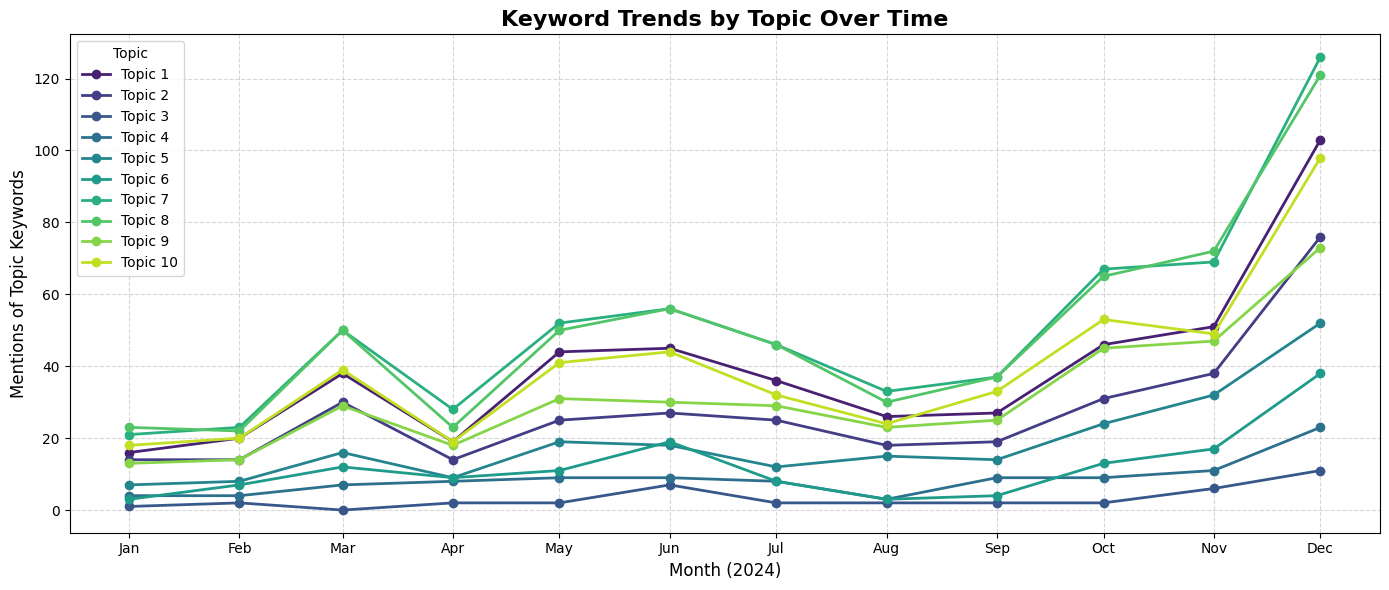

In [153]:
plot_keyword_trends_by_topic(df, topic_words, text_col="summary_clean", top_n=10)

 **Keyword Trends Summary (2024)**

- **December spike**: All topics peak in Dec
- **Most active**: **Topics 6, 7, 10** dominate overall; likely key themes like *video diffusion* or *control methods*.
- **Least active**: **Topics 3, 4, 5** stay low — possibly niche or less trending.
- **Mid-year bump**: Minor rise around **May–June**.

## **Conclusion**

In this analysis, articles from arXiv published in 2024 on the topic of "video generation" were collected and processed. Using the NMF algorithm, key topics were identified and visualized through graphs and time series. The results illustrate the distribution of publications by month and weekday, highlight the most frequent phrases and the most active authors, and can serve as a foundation for further research in the field of video generation.

*Key takeaways:*
- 10 core topics were identified, reflecting the dynamics of publication trends.
- Keywords and their relationships provide deeper insight into the thematic focus of the research.
- Data was compiled, analyzed, and visualized to support meaningful interpretation of trends in the "video generation" domain.

## **Sources**

[1]: GitHub repository for arxiv.py – [https://github.com/lukasschwab/arxiv.py](https://github.com/lukasschwab/arxiv.py)  
[2]: arXiv API documentation – [https://info.arxiv.org/help/api/index.html](https://info.arxiv.org/help/api/index.html)